# Modeling fish production, using Stock et al. 2017 equations. (but excluding the alpha to get production from estimated catch)
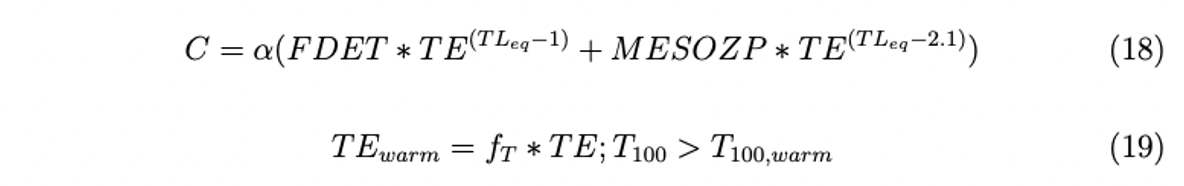

__{$\alpha$}__ = harvesting factor interpreted as the fraction of energy available at TL$_{eq}$ that is realized as catch

* in Stock et al. 2017, single values of TE and $\alpha$  are fit across LMEs such that any interregional variation in these parameters would appear as unexplained catch variance

* __{$\alpha$} was constrained between 0 and 1.__ 

__FDET__ = energy available from the plankton food web via the flux of detritus to sediment 

__TE__ = trophic transfer efficincy, controlling the decay of energy between trophic levels. This is a dimensionless free paramter controlling the decay of energy between trophic levels. 

* __values of TE were constrained within typical observed ranges of 0-0.4__
    * (Pauly D, Christensen V (1995) Primary production required to sustain global fisheries. Nature 374(6519):255–257.)
    * Libralato S, Coll M, Tudela S, Palomera I, Pranovi F (2008) Novel index for quantification of ecosystem effects of fishing as removal of secondary production. Mar Ecol Prog Ser 355:107–129.

__TL$_{eq}$__ = equivalent trophic level of the aggreagte catch derived from FishBase. It scaled by a trophic level of 1 for FDET and 2.1 for MESOZP from the fish catch. 

* Phytoplankton are assigned to trophic level 1, such that TL$_{eq}$ - 1 is the number of trophic steps separating phytoplankton from the fish catch.  

__MESOZP__ = mesozooplankton production not consumed by other zooplankton


In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import seaborn as sns
import scipy.io as sio
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [4]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

### __FDET__ = energy available from the plankton food web via the flux of detritus to sediment 

In [5]:
ds.POC_FLUX_IN

<xarray.DataArray 'POC_FLUX_IN' (time: 12, z_t: 60, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(12, 60, 384, 320), dtype=float32, chunksize=(1, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     POC Flux into Cell
    units:         mmol/m^3 cm/s
    grid_loc:      3111
    cell_methods:  time: mean

In [6]:
Flux = ds.POC_FLUX_IN[:,:,:,:].mean(dim='time') * (60*60*24*365)/100 * 12.011 / 1e3 # mmol/m^3 cm/s --> mmol/m^2/y ----> g/m^2/y

kmt_bottom = np.nanmean(ds.KMT,axis=0)
flux_bottom = np.empty([12,384,320]) # Size of the array that I need
flux_bottom[:] = np.nan # make everything a nan inside of it
for i in range(384): # loop through the latitude 
    for j in range(320): # loop through the longitude 
        # For each lat and lon, find the bottom depth, and select that flux as the bottom flux of each grid cell. 
        # I averaged the bottom depth annually before becuase I do not expect the bottom depth to change seasonally right?
        if kmt_bottom[i,j] == 0: 
            flux_bottom[:,i,j] =  ds.POC_FLUX_IN[:,0,i,j]# mmol/m^3 cm/s
        else:
            flux_bottom[:,i,j] =  ds.POC_FLUX_IN[:,np.int(kmt_bottom[i,j])-1,i,j]# mmol/m^3 cm/s
            
            
np.save("/glade/scratch/gabyn/SPECTRA/flux_bottom.npy",flux_bottom)

In [7]:
flux_bottom = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/flux_bottom.npy")

In [8]:
flux_bottom.shape

(12, 384, 320)

In [9]:
flux_bottom_depth = np.nanmean(flux_bottom,axis=0) * (60*60*24*365)/100 * 12.011 / 1e3 #g/m^2/y

### Compare FDET/NPP with Stock et al. 2017

In [10]:
total_npp = ds.photoC_TOT.sum(dim='z_t_150m') * 10 # (10 = depth of each layer) integrate over depth mmol/m^3/s to #mmol m-2 s-1
total_npp = total_npp.mean(dim='time') * (60*60*24*365) # mmol m-2 y-1
total_npp = total_npp * 12.011 / 1e3 # g/m^2/y

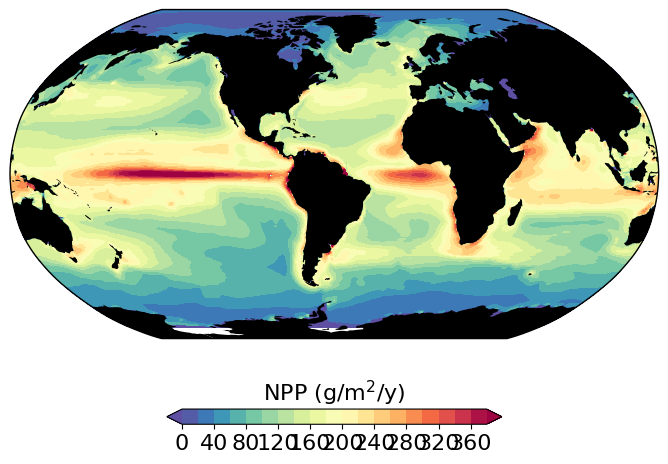

In [11]:
fig = plt.figure(figsize=(7, 5))
lev = np.arange(0, 400, 20)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=200)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, total_npp)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('NPP (g/m$^2$/y)', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

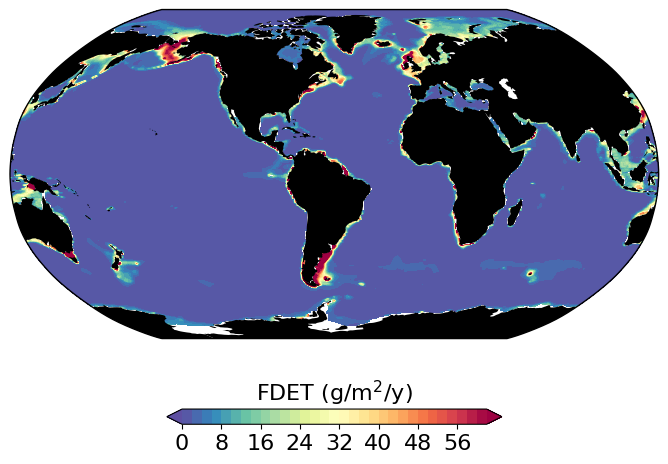

In [12]:
fig = plt.figure(figsize=(7, 5))
lev = np.arange(0, 64, 2)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=32)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, flux_bottom_depth)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('FDET (g/m$^2$/y)', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

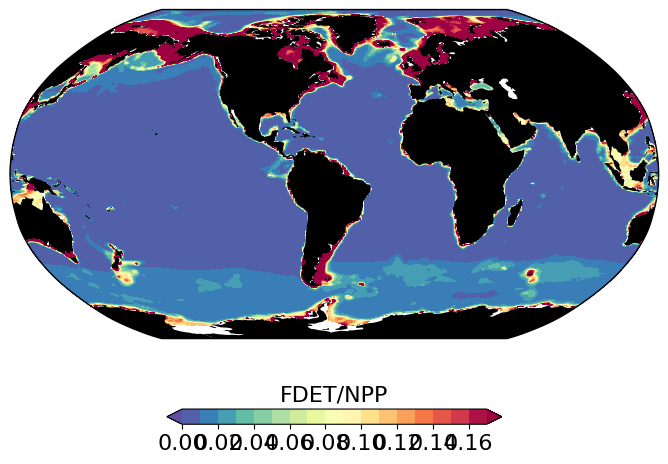

In [13]:
fig = plt.figure(figsize=(7, 5))
lev = np.arange(0, 0.18, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.09)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, flux_bottom_depth/total_npp)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('FDET/NPP', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

### __MESOZP__ = mesozooplankton production not consumed by other zooplankton
* Here, I will use zooplankton production - zooplankton grazing on zooplankton of each category

In [14]:
# sum of Mesozooplankton Grazing Gain Vertical Integral mol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooGraz'] = xr.concat([ds['x_graze_' + v + '_zint'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooGraz_TOT = np.nansum(ds.zooGraz,axis=0) *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [15]:
# zooplankton Linear loss vertical Intergral mmol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooLoss'] = xr.concat([ds[''+ v + '_linear_loss_zint'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooloss_TOT = np.nansum(ds.zooLoss,axis=0) *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [16]:
zooProduction = np.subtract(zooGraz_TOT, zooloss_TOT)

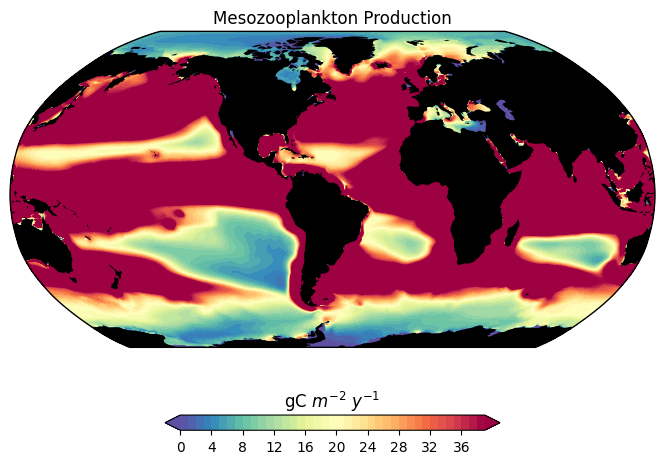

In [17]:
lev = np.arange(0, 40, 1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=20)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooProduction)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('gC $m^{-2}$ $y^{-1}$')
ax.set_title('Mesozooplankton Production');
plt.tight_layout()

In [18]:
# Mesozooplankton production.. 
zoo3_prod = np.subtract(ds.x_graze_zoo3_zint, ds.zoo3_linear_loss_zint)
zoo4_prod = np.subtract(ds.x_graze_zoo4_zint, ds.zoo4_linear_loss_zint)
zoo5_prod = np.subtract(ds.x_graze_zoo5_zint, ds.zoo5_linear_loss_zint)
zoo6_prod = np.subtract(ds.x_graze_zoo6_zint, ds.zoo6_linear_loss_zint)

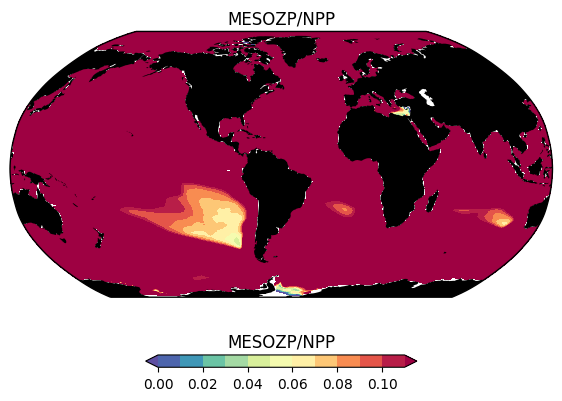

In [19]:
fig = plt.figure(figsize=(7, 5))
lev = np.arange(0, 0.12, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.06)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooProduction/total_npp)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('MESOZP/NPP')
ax.set_title('MESOZP/NPP');

### Grazing flux based on trophic level 

In [20]:
## Gaby's Path 
jluo_path = '/glade/u/home/jluo/cesm_scripts/size_structured/nl_input/cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
gabyn_path = '/glade/work/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+'GNG595/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')
sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


In [5]:
ZooTL_g = np.load("/glade/u/home/gabyn/Notebook_scripts/Chapter2/Question_5/Fish_Production_20yr_avg/mesozoo_mean_TL.npy")

In [6]:
ZooTL_g.shape

(12, 15, 384, 320)

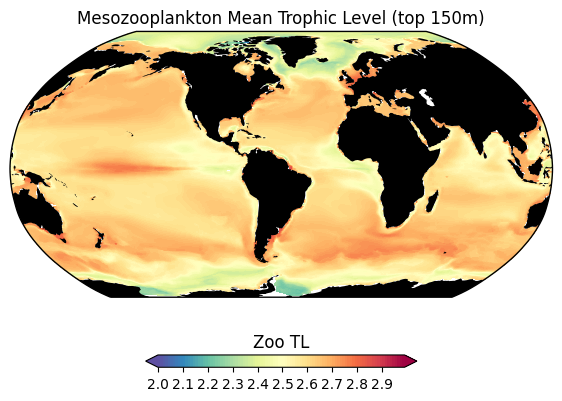

In [9]:
lev = np.arange(2, 3, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(ZooTL_g,axis=(0,1)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r', levels = lev, norm = norm,extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zoo TL')
ax.set_title('Mesozooplankton Mean Trophic Level (top 150m)');

### Calculating fish Production 

In [24]:
alpha = 1 # ranges from 0 to 1 
FDET = flux_bottom_depth # POC Flux into Cell (mmol/m^3 cm/s) to g C / m^2 s
TE = 0.2 # ranges from 0 to 0.4 
TE_eq = 3 # trophic level (np.nanmean(ZooTL_g,axis=(0,1,2,3))) ---> (2.5885172746837832)
MESOZP =  zooProduction # g C / m^2 s

In [25]:
Catch = alpha*((FDET*TE**(TE_eq-1))+(MESOZP*TE**(TE_eq-np.nanmean(ZooTL_g,axis=(0,1,2,3)))))

Text(0.5, 1.0, 'Fish Production')

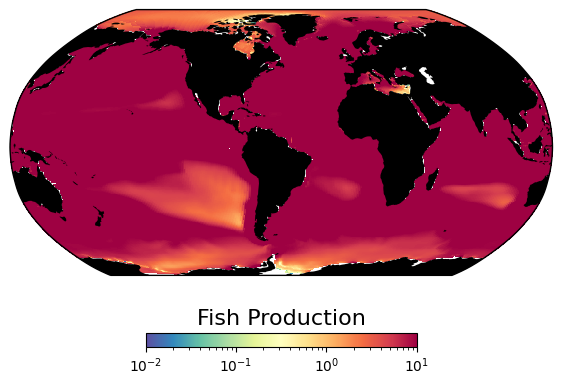

In [26]:
fig = plt.figure(figsize=(7, 5))
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Fish Production', fontsize=16)

## Arctic Fish Production! 

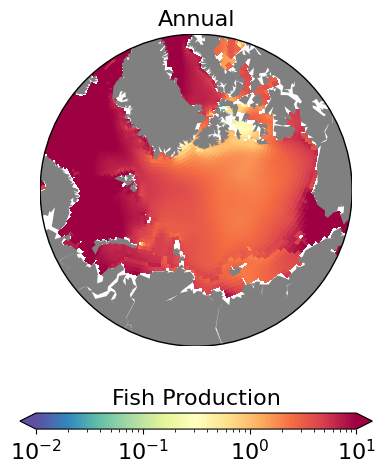

In [27]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(2, 3, 0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
fig = plt.figure(figsize=(5, 5))

# Annual TL3
ax = fig.add_subplot(1, 1, 1)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, Catch)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Production', fontsize=16)
ax.set_title('Annual', fontsize =16)
cb.ax.tick_params(labelsize=16)

plt.tight_layout()

#### Now make a plot with three pannels:
    1. Flux Production (Benthic Flux)
    2. Pelagic Fish Production 
    3. Flux/Pelagic 

In [28]:
zooProduction[zooProduction<0]=0

In [29]:
alpha = 1 # ranges from 0 to 1 
FDET = np.nanmean(Flux[:,:,:],axis=0) # POC Flux into Cell (mmol/m^3 cm/s) to g C / m^2 s
FDET_pelagic =Flux[15,:,:] #g/m^2/y
FDET_benthic = flux_bottom_depth
TE = 0.2 # ranges from 0 to 0.4 
TE_eq = 3 # trophic level (np.nanmean(ZooTL_g,axis=(0,1,2,3))) ---> (2.5885172746837832)
MESOZP =  zooProduction # g C / m^2 s
### Pelagic Fish Production 
pelagic = (MESOZP*TE**(TE_eq-np.nanmean(ZooTL_g,axis=(0,1,2,3))))
### Benthic Fish Production 
benthic = (FDET_benthic*TE**(TE_eq-1))

## Benthic/Pelagic
ratio = benthic/pelagic

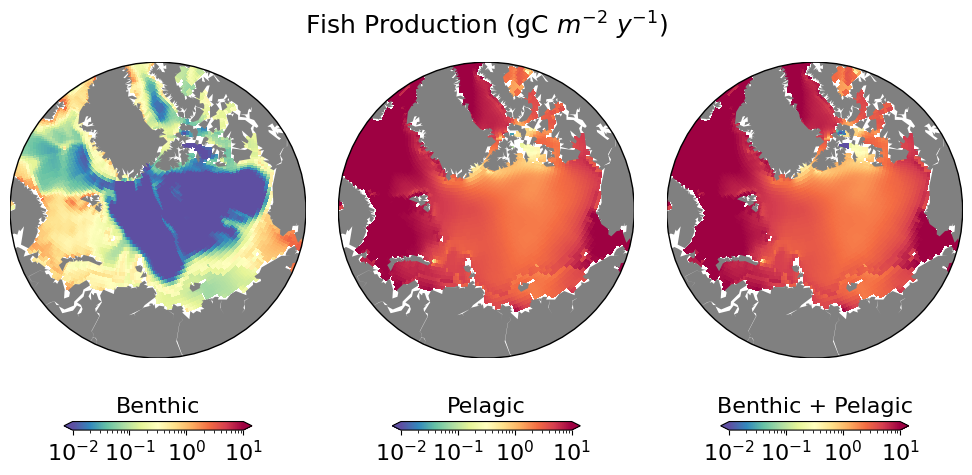

In [31]:
lev = np.arange(2, 3, 0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
fig = plt.figure(figsize=(10, 5))

# Ammual TL3
ax = fig.add_subplot(1, 3, 1)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, benthic)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.6, extend ='both',orientation='horizontal')
cb.ax.set_title('Benthic', fontsize=16)
cb.ax.tick_params(labelsize=16)

# Pelagic Fish Production 
ax = fig.add_subplot(1, 3, 2)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, pelagic)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.6, extend ='both',orientation='horizontal')
cb.ax.set_title('Pelagic', fontsize=16)
cb.ax.tick_params(labelsize=16)

# Pelagic Fish Production 
ax = fig.add_subplot(1, 3, 3)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, benthic+pelagic)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.6, extend ='both',orientation='horizontal')
cb.ax.set_title('Benthic + Pelagic', fontsize=16)
cb.ax.tick_params(labelsize=16)
fig.suptitle('Fish Production (gC $m^{-2}$ $y^{-1}$)',fontsize=18)

plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/FishProduction_TL3_AO_20yrclim_Benthic_Pelagic.png',dpi=600, bbox_inches='tight')